In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from tqdm import tqdm_notebook

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import networkx as nx
from ipywidgets import interactive

%matplotlib inline

In [2]:
def read_data(name):
    
    result = {"cumulative_cities":[], "daily_cities":[], "total_infected":[]}
    
    for simulation in range(10):
        with open(f"{name}_0", 'rb') as f:
            data = pickle.load(f)
#         print(data)
        data = pd.DataFrame(data).T
        cumulative_cities = np.cumsum(data.groupby('day')['infected'].count())
#         print(cumulative_cities)
        daily_cities = data.groupby('day')['infected'].count()
        total_infected = data['infected'].apply(np.max).sum()

        result["cumulative_cities"].append(cumulative_cities)
        result["daily_cities"].append(daily_cities)
        result["total_infected"].append(total_infected)
        
    return result

def plot_with_std(data, label, color):
    average = data.mean()
    std = data.std()
    
    plt.plot(
        average, 
        label=label, 
        color=color, 
        linewidth=2
    )

    plt.fill_between(range(len(average)), average+std, average, alpha=0.1, color=color)
    plt.fill_between(range(len(average)), average-std, average, alpha=0.1, color=color)

In [3]:
realistic = read_data("../data/INFECTED_CITIES")
df = pd.DataFrame(realistic) 
df.to_csv("../data/ripan.csv")

In [4]:
airport_data = pd.read_csv("../data/airport_data_preprocessed.csv", index_col=0)
airport_data.head()

,ID,Name,City,Country,IATA,Lat,Long,population,source_airport,flights_per_month,flights_coefficient
0,3411,Barter Island LRRS Airport,Barter Island,United States,BTI,70.134003,-143.582001,9121.0,BTI,27.0,337.810107
1,3413,Cape Lisburne LRRS Airport,Cape Lisburne,United States,LUR,68.875099,-166.110001,1352.0,LUR,4.0,337.810107
2,3414,Point Lay LRRS Airport,Point Lay,United States,PIZ,69.732903,-163.005005,9121.0,PIZ,27.0,337.810107
3,3415,Hilo International Airport,Hilo,United States,ITO,19.721399,-155.048004,43263.0,ITO,634.0,337.810107
5,3417,Bettles Airport,Bettles,United States,BTT,66.913902,-151.529007,10473.0,BTT,31.0,337.810107


In [5]:
realistic_label = 'Quarantines after 100 days, 50 days to enforce (R0=4, R44=1)'

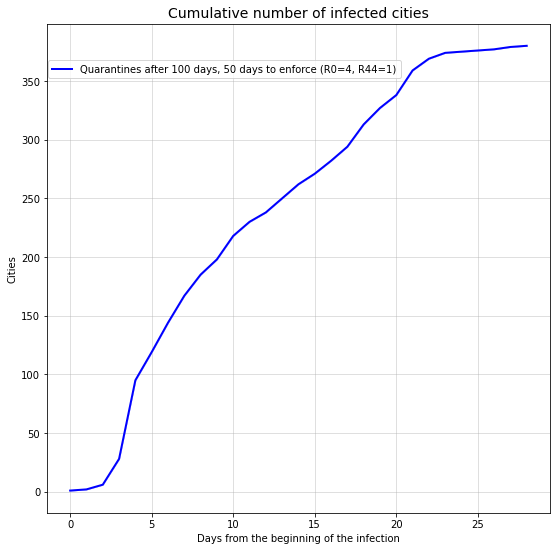

In [6]:
plt.figure(figsize=(9, 9))
plot_with_std(pd.DataFrame(realistic['cumulative_cities']), 
              label=realistic_label,
              color='blue'
             )

plt.title("Cumulative number of infected cities", fontsize=14)
plt.ylabel("Cities")
plt.xlabel("Days from the beginning of the infection")
plt.grid(alpha=0.5)
plt.legend(loc=(0.002,0.888))
plt.show()

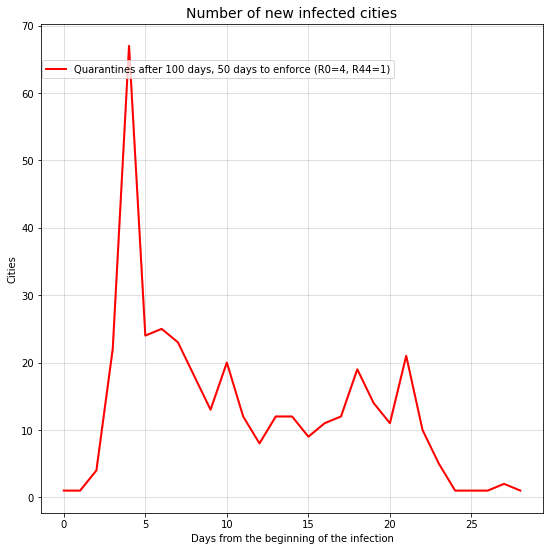

In [7]:
plt.figure(figsize=(9, 9))
plot_with_std(pd.DataFrame(realistic['daily_cities']), 
              label=realistic_label,
              color='red'
             )

plt.title("Number of new infected cities", fontsize=14)
plt.ylabel("Cities")
plt.xlabel("Days from the beginning of the infection")
plt.grid(alpha=0.5)
plt.legend(loc=(0.002,0.888))
plt.show()

In [8]:
def get_spread_data(file_name, airport_data=airport_data):	
    with open(file_name, 'rb') as f:	
        spread_data = pickle.load(f)	
        	
    spread_data = pd.DataFrame(spread_data).T	
    spread_data = spread_data[['from', 'day']].reset_index()	
    spread_data.columns = ['destination', 'source', 'day']	
    spread_data = spread_data[['source', 'destination', 'day']]	
    	
    spread_data = pd.merge(	
        spread_data, airport_data[['City', 'Lat', 'Long']], left_on='source', right_on='City')	
    spread_data = pd.merge(	
        spread_data, airport_data[['City', 'Lat', 'Long']], left_on='destination', right_on='City')	
    spread_data.drop(['City_x', 'City_y'], axis=1, inplace=True)	
    spread_data.rename(columns={	
        'Lat_x':'latitude_source', 	
        'Long_x':'longitude_source',	
        'Lat_y':'latitude_dest',	
        'Long_y':'longitude_dest'	
    }, inplace=True)	
    	
    return spread_data	
def get_graph(result_cities, airport_data=airport_data):	
    graph = nx.from_pandas_edgelist(	
        result_cities, 	
        source = 'source', 	
        target = 'destination',	
        create_using = nx.DiGraph()	
    )	
    xycoords = {}	
    for node in tqdm_notebook(list(graph.nodes), leave=False):	
        xycoords[str(node)] = (	
            airport_data.Long[airport_data.City ==node].values[0], 	
            airport_data.Lat[airport_data.City == node].values[0]	
        )	
    return graph, xycoords	
def visualise_spread(x):	
    graph = nx.from_pandas_edgelist(	
        result_cities[result_cities.day<=x], 	
        source = 'source', 	
        target = 'destination',	
        create_using = nx.DiGraph()	
    )	
    plt.figure(figsize=(40, 20))	
    ax = plt.axes(projection=ccrs.PlateCarree())	
    ax.coastlines()	
    ax.add_feature(cfeature.LAND, color='#B68E56')	
    ax.add_feature(cfeature.OCEAN, color='#207D9C')	
    ax.add_feature(cfeature.COASTLINE)	
    ax.add_feature(cfeature.BORDERS)	
    ax.outline_patch.set_visible(False)	
    nx.draw_networkx(graph,	
                 arrows=True,	
                 pos=xycoords,	
                 with_labels=False,	
                 node_color='#A62823',	
                 edge_color='#F9FAEC',	
                 style='dashed',	
                 arrowstyle='-',	
                 node_size=35,	
                 alpha=1)	
    	
    plt.xlim(-170, -60)	
    plt.ylim(10, 80) 	
    plt.show()

/opt/anaconda3/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:387: MatplotlibDeprecationWarning: 
The 'inframe' parameter of draw() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use Axes.redraw_in_frame() instead. If any parameter follows 'inframe', they should be passed as keyword, not positionally.
  return matplotlib.axes.Axes.draw(self, renderer=renderer,


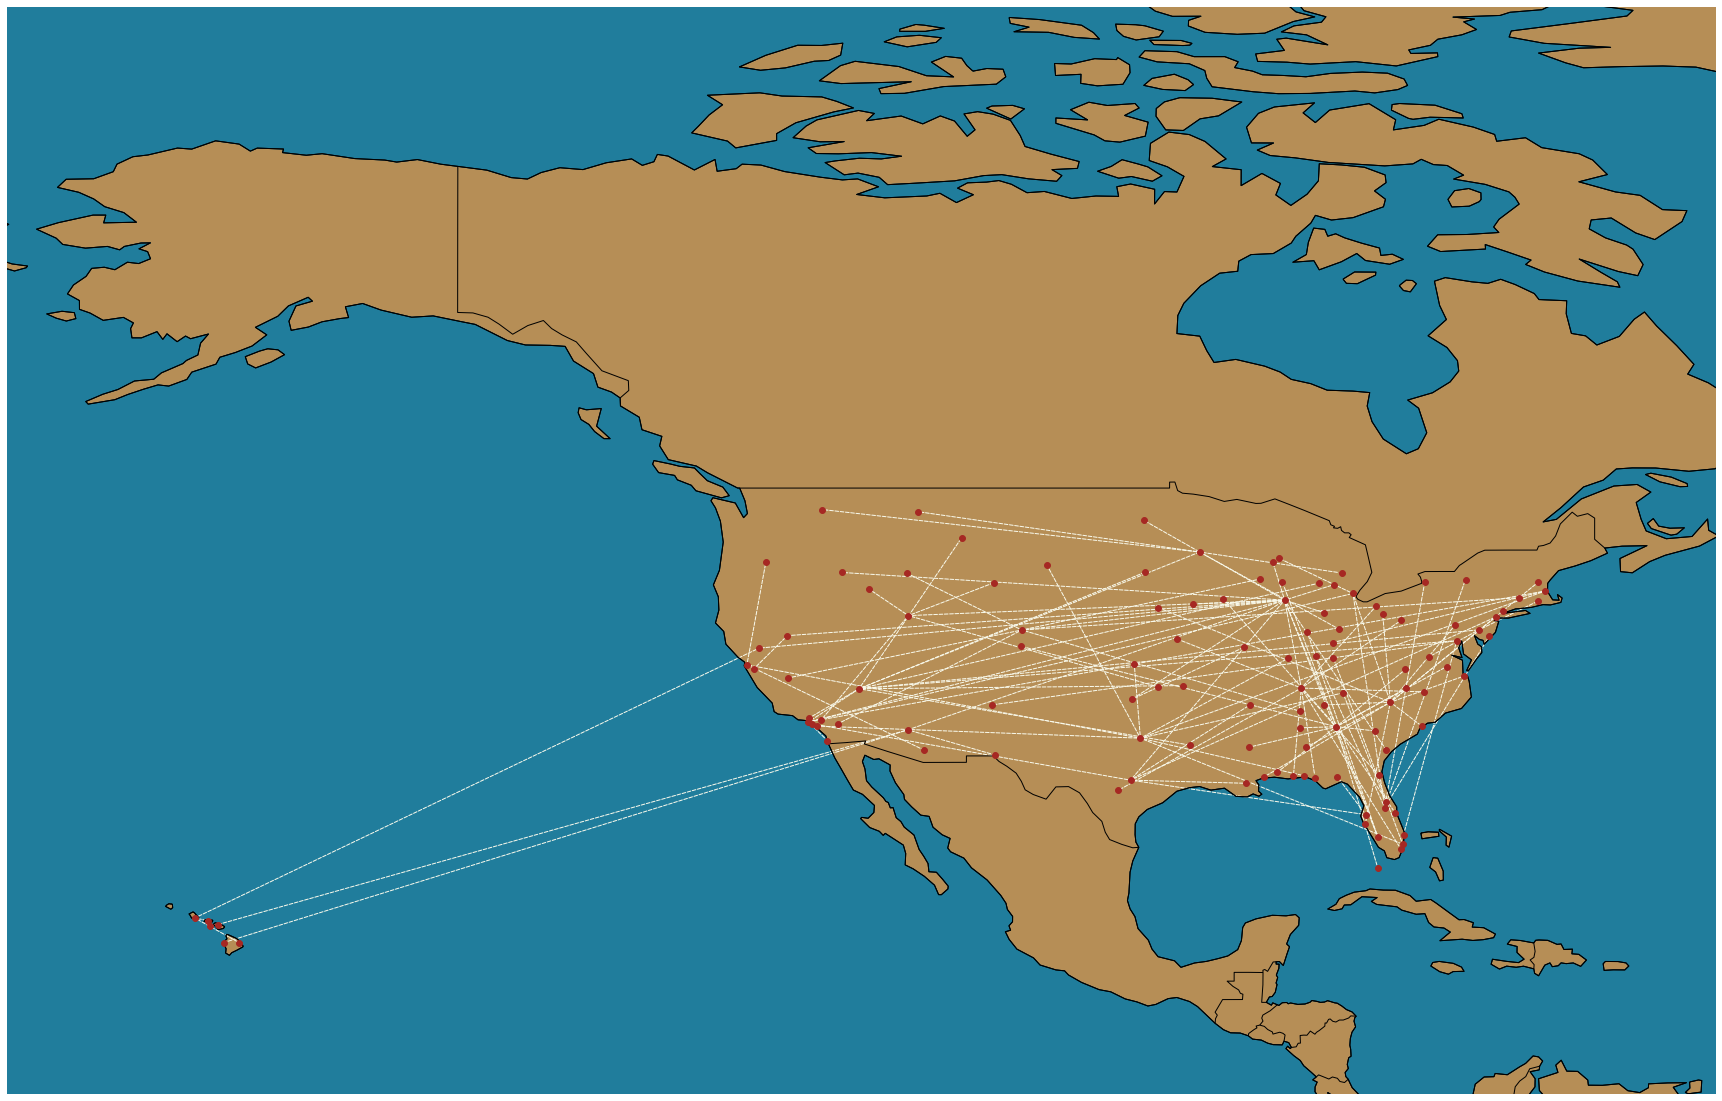

In [9]:
result_cities = get_spread_data("../data/INFECTED_CITIES_0")
graph, xycoords = get_graph(result_cities)

interactive_plot = interactive(visualise_spread, 
                               x=5
                              )
interactive_plot